### Benchmark the numerical GPU solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
# set up the model size
nx = 201
nz = 101
dx = 20.0
dz = 20.0
x = np.arange(0, nx * dx, dx)
z = np.arange(0, nz * dz, dz)

# set up the model parameters
vp = np.ones((nz, nx)) * 4000.0
vs = np.ones((nz, nx)) * 4000.0 / 1.732
rho = np.ones((nz, nx)) * 2500.0

# set up the source and receiver
ind_src_x =   np.arange(10, nx-10, 10).astype(int)
ind_src_z = 1*np.ones(ind_src_x.shape[0]).astype(int)
ind_rec_x =   np.arange(10, nx-10).astype(int)
ind_rec_z =90*np.ones(ind_rec_x.shape[0]).astype(int)

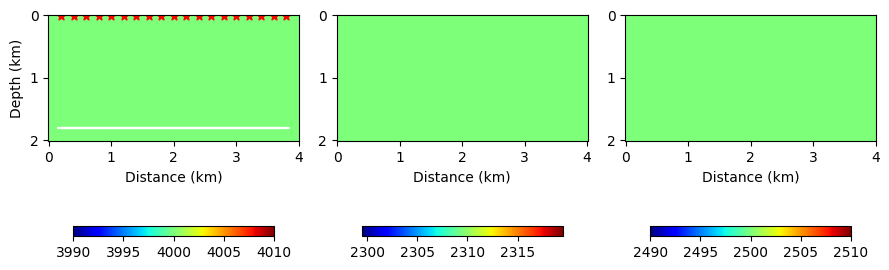

In [3]:
fig = plt.figure(figsize=(9, 6))
for i, m in enumerate([vp, vs, rho]):
    ax = plt.subplot(1,3,i+1)
    im = ax.pcolor(x/1000, z/1000, m, cmap='jet', vmin = m.min()-10, vmax= m.max()+10)
    if i == 0:
        plt.scatter(ind_src_x*dx/1000, ind_src_z*dz/1000, color='r', marker = '*')
        plt.scatter(ind_rec_x*dx/1000, ind_rec_z*dz/1000, color='w', marker = '_')

    fig.colorbar(im, shrink=0.8, location = 'bottom', orientation = 'horizontal')
    plt.gca().invert_yaxis()
    ax.set_aspect('equal')
    plt.xlabel('Distance (km)')
    if i==0:
        plt.ylabel('Depth (km)')
plt.tight_layout()
plt.savefig('./Fig/001-Fig-Homo-model.png', dpi=300, bbox_inches='tight')

In [4]:
# save the model to be used by the GPU code
path_save = './Models/'
np.savetxt(path_save+"HOMO-P-WAVE-VELOCITY-101-201.txt", vp)
np.savetxt(path_save+"HOMO-S-WAVE-VELOCITY-101-201.txt", vs)
np.savetxt(path_save+"HOMO-DENSITY-101-201.txt",        rho)

### Run the numerical solver on the GPU

In [5]:
! python Main-000-Forward-Benchmark.py --generate_data

Detected CUDA files, patching ldflags
Emitting ninja build file /home/users/haipeng/TorchFWI/Ops/FWI/Src/build/build.ninja...
Building extension module fwi...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module fwi...
vp_true_pad shape = (192, 265)
End of Data Generation


### Check results

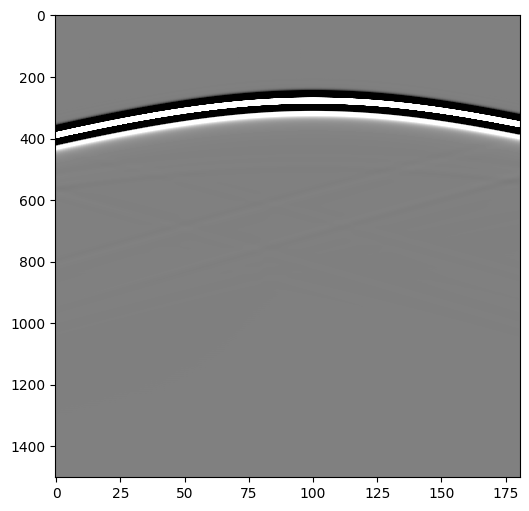

In [6]:
isrc = 10
path = '/scratch/users/haipeng/000-Forward-Benchmark/'
data = np.fromfile(f'{path}/Data/Shot_pr{isrc}.bin', dtype=np.float32).reshape(-1, 1501)

fig = plt.figure(figsize=(6, 6))
clim = np.percentile(np.absolute(data), 95)
plt.imshow(data.T, aspect='auto', cmap='gray', vmin = -clim, vmax=clim)

### Benckmark with the numerical results

In [7]:
from analyticalSolution import AnalyticalSolution

In [8]:
# set up the model size
nx = 201
nz = 101
dx = 20.0
dz = 20.0
x = np.arange(0, nx * dx, dx)
z = np.arange(0, nz * dz, dz)

# set up the model parameters
vp_ana = 4000.0
vs_ana = 4000.0 / 1.732
rho_ana = 2500.0

# set up source parameters
M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) # Moment tensor
f0   = 10.0               # Dominant frequency (Hz)
M0   = 1*1e16             # Scalar Moment 
tmin = 0.0                # Minimum observation time (s)
tmax = 1.0                # Maximum observation time (s)
dt   = 0.002              # Time interval (s)

In [9]:
# set up location of receiver
isrc = 10
igeo = 40

rec_x = abs(ind_rec_x[igeo] - ind_src_x[isrc]) * dx    # x receiver coordinate 
rec_z = abs(ind_rec_z[igeo] - ind_src_z[isrc]) * dz    # z receiver coodinate
rec_y = 0                                                   # y receiver coodinate

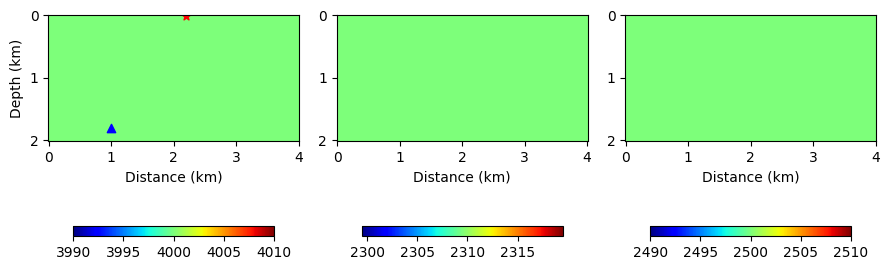

In [10]:
fig = plt.figure(figsize=(9, 6))
for i, m in enumerate([vp, vs, rho]):
    ax = plt.subplot(1,3,i+1)
    im = ax.pcolor(x/1000, z/1000, m, cmap='jet', vmin = m.min()-10, vmax= m.max()+10)
    if i == 0:
        plt.scatter(ind_src_x[isrc]*dx/1000, ind_src_z[isrc]*dz/1000, color='r', marker = '*')
        plt.scatter(ind_rec_x[igeo]*dx/1000, ind_rec_z[igeo]*dz/1000, color='b', marker = '^')

    fig.colorbar(im, shrink=0.8, location = 'bottom', orientation = 'horizontal')
    plt.gca().invert_yaxis()
    ax.set_aspect('equal')
    plt.xlabel('Distance (km)')
    if i==0:
        plt.ylabel('Depth (km)')
plt.tight_layout()
plt.savefig('./Fig/001-Fig-Homo-model-benchmark.png', dpi=300, bbox_inches='tight')

In [11]:
solu_2D = AnalyticalSolution(vp_ana, vs_ana, rho_ana, rec_x, rec_y, rec_z, tmin, tmax, dt, f0, M0, M, dim='2D', comp = 'displacement', verbose = True)

------------------------------------------------------------
 Input parameters for computing the analytical solution:
     dim  = 2D
     comp = displacement
     vp   = 4000.00 m/s
     vs   = 2309.47 m/s
     rho  = 2500.00 kg/m^3
     x    = 1200.00 m
     y    = 0.00 m
     z    = 1780.00 m
     tmin = 0.00 s
     tmax = 1.00 s
     dt   = 2.00e-03 s
     f0   = 10.00 Hz
     M0   = 1.00e+16 Nm
     M    = [1. 0. 0.]
            [0. 1. 0.]
            [0. 0. 1.]
------------------------------------------------------------
Calculating 2D solution by integrating 3D solution from 1040 receivers ...


100%|██████████| 1040/1040 [04:19<00:00,  4.00it/s]


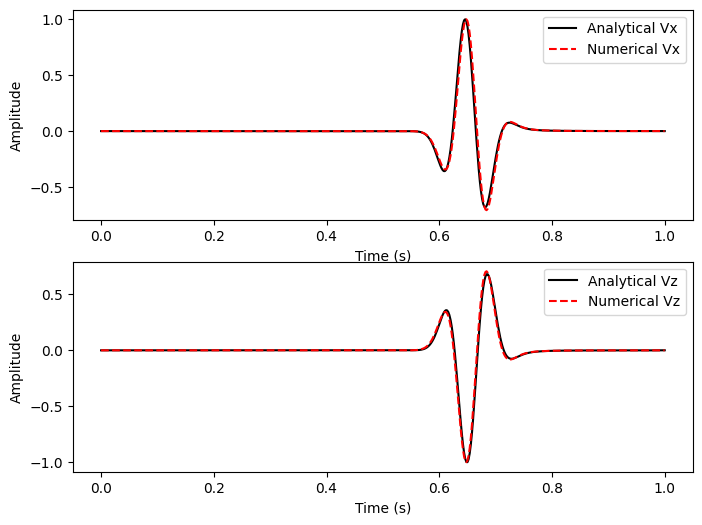

In [12]:
fig = plt.figure(figsize=(8, 6))

plt.subplot(2,1,1)
data = np.fromfile(f'{path}/Data/Shot_vx{isrc}.bin', dtype=np.float32).reshape(-1, 1501)
plt.plot(solu_2D['t'], data[igeo, :501].T / np.max(abs(data[igeo, :501])), 'k-')
plt.plot(solu_2D['t'], solu_2D['Ux'] / np.max(abs(solu_2D['Ux'])), 'r--')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Analytical Vx', 'Numerical Vx'])


plt.subplot(2,1,2)
data = np.fromfile(f'{path}/Data/Shot_vz{isrc}.bin', dtype=np.float32).reshape(-1, 1501)
plt.plot(solu_2D['t'], data[igeo, :501].T / np.max(abs(data[igeo, :501])), 'k-')
plt.plot(solu_2D['t'], -solu_2D['Uz'] / np.max(abs(solu_2D['Uz'])), 'r--')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Analytical Vz', 'Numerical Vz'])

# The wavelet is differently dealt with in the analytical and numerical solutions.
# The direction is defined differentlt in these two code.